In [2]:
from sklearn.decomposition import PCA
import numpy as np
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
import datetime as dt
import datetime

def obs_range(pre_entry_bars):
    high = pre_entry_bars.high.max()
    low = pre_entry_bars.low.min()
    return (high - low)

def obs_dis_from_mid_pt(pre_entry_bars):
    high = pre_entry_bars.high.max()
    low = pre_entry_bars.low.min()
    return ((pre_entry_bars.close.iloc[-1]-low)/(high-low)) - 0.5

def obs_abs_return(pre_entry_bars):
    return abs(pre_entry_bars.close.iloc[-1] - pre_entry_bars.open.iloc[0])

def obs_return(pre_entry_bars):
    return (pre_entry_bars.close.iloc[-1] - pre_entry_bars.open.iloc[0])

In [3]:
### This is the cell for reading the csvs
# The first line is for loading the larger dataset
# the second line which I commented out is for the two closest weeks that we tested
# last time


sf = pd.read_csv('USD_CNH_BID.csv')
# sf = pd.read_csv('TRUTH/USD_CNH_BID.csv',parse_dates = [0])

candles = pd.read_csv('fixed_HSI2Y.csv', parse_dates=['datetime'])
# candles = pd.read_csv('TRUTH/THE_TRUTH.csv', parse_dates=['datetime'])

technical = pd.read_csv('daily_technicals.csv', parse_dates=[0])
# technical = pd.read_csv('TRUTH/daily_technicals.csv', parse_dates=[0])

In [23]:
technical.columns

Index(['yes_1_SMA', 'yes_2_SMA', 'yes_5_SMA', 'yes_10_SMA', 'yes_20_SMA',
       'yes_50_SMA', 'yes_100_SMA', 'yes_200_SMA', 'yes_250_SMA',
       'yes_1_SMA_diff', 'yes_2_SMA_diff', 'yes_5_SMA_diff', 'yes_10_SMA_diff',
       'yes_20_SMA_diff', 'yes_50_SMA_diff', 'yes_100_SMA_diff',
       'yes_200_SMA_diff', 'yes_250_SMA_diff', 'yes_5_EMA', 'yes_10_EMA',
       'yes_12_EMA', 'yes_20_EMA', 'yes_26_EMA', 'yes_50_EMA', 'yes_100_EMA',
       'yes_200_EMA', 'yes_250_EMA', 'yes_5_EMA_diff', 'yes_10_EMA_diff',
       'yes_12_EMA_diff', 'yes_20_EMA_diff', 'yes_26_EMA_diff',
       'yes_50_EMA_diff', 'yes_100_EMA_diff', 'yes_200_EMA_diff',
       'yes_250_EMA_diff', 'High', 'Low', 'Volume', 'pivotpt', 'resistance[1]',
       'support[1]', 'resistance[2]', 'support[2]', 'resistance[3]',
       'support[3]', 'resistance[4]', 'support[4]', 'resistance[5]',
       'support[5]', 'Bandwidth', 'BB_upper', 'BB_lower', 'MACD_DIF',
       'MACD_DEM', 'MACD_OSC'],
      dtype='object')

In [4]:
# This is the code for getting the dataframe, ideally you just have
# to run it once in your analysis, since it takes a while
# note that it is for 80, 20 position prediction



sf.rename(columns={'Unnamed: 0': 'Time'}, inplace=True)

sf = sf.sort_values('Time')

sf['Time'] = sf['Time'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
# sf = sf[sf.Time >= '2017-01-01']


# check na
# sf.isnull().values.sum()

trigger_time = datetime.time(9,45)

sf['No_date'] = sf['Time'].apply(lambda x: True if (x.time() >= datetime.time(6,30)) and 
                                   (x.time() <= trigger_time) else False)

ssf = pd.DataFrame(sf[list(sf['No_date'])], index=None).reset_index(drop=True)

for i in range(1,13):
    ssf['%i min open return' %(i*5)] = float('nan')

for j in range(1,13):
    row_iterator = ssf.iterrows()
    _, last = next(row_iterator)
    
    for i, row in row_iterator:
        if row['Time'].time() == (datetime.datetime.strptime('{:%H:%M}'.format(trigger_time), '%H:%M') - datetime.timedelta(minutes = 5*(j-1))).time():
            ssf.loc[i+j-1, '%i min open return' %(j*5)] = (row['open'] - last['open'])/last['open']*100
        last = row

for i in range(1,7):
    ssf['%i half hour open return' %(i)] = float('nan')

for j in range(1,7):
    row_iterator = ssf.iterrows()
    _, last = next(row_iterator)
    
    for i, row in row_iterator:
        if row['Time'].time() == (datetime.datetime.strptime('{:%H:%M}'.format(trigger_time), '%H:%M') - datetime.timedelta(minutes = 30*(j-1))).time():
            ssf.loc[i+(j-1)*6, '%i half hour open return' %(j)] = (ssf.loc[i, 'open']- ssf.loc[i-6, 'open'])/ssf.loc[i-6, 'open']*100

ssf.dropna(inplace=True)
ssf.reset_index(inplace=True)
# ssf.to_csv('CNH_USD_BID_CHANGE_9:45.csv')

variables=[obs_abs_return,obs_dis_from_mid_pt,obs_range,obs_return]
variables_table = []


#read input of market and their time
pre_market_open = dt.datetime.strptime('09:15', '%H:%M')
market_open = dt.datetime.strptime('09:30' , '%H:%M')
market_close = dt.datetime.strptime('16:30' , '%H:%M')
entry_time = dt.datetime.strptime('09:45' , '%H:%M')

#identifying start date and end date as well as let us to get access of the date
candle_timestamps = set(candles.datetime)
candles['date'] = candles.datetime.map(lambda x: x.date())
candles['time'] = candles.datetime.map(lambda x: x.time())
start = candles.date.min()
end = candles.date.max()
date_count = (end - start).days + 1
market_open_length = int((market_close - market_open).seconds/60)
market_observe_length = int((entry_time - pre_market_open).seconds/60)


marketdays = []

for date in (start + dt.timedelta(n) for n in range(date_count)):
    #check if it is a full day market or not
    if not(pd.Timestamp(dt.datetime.combine(date,(market_open).time())) in candle_timestamps):
        candles = candles[(candles.datetime < dt.datetime.combine(date, dt.time(9,15))) | (candles.datetime >= dt.datetime.combine(date + dt.timedelta(days = 1), dt.time(0,55)))]
        continue
    if not(dt.datetime.combine(date, (market_close + dt.timedelta(minutes = -5)).time()) in candle_timestamps):
        candles = candles[(candles.datetime < dt.datetime.combine(date, dt.time(9,15))) | (candles.datetime >= dt.datetime.combine(date + dt.timedelta(days = 1), dt.time(0,55)))]
        continue
    marketdays.append(date)

yes_after_market_bars = []
pre_market_bars = []
pre_entry_bars = []
post_entry_bars = []
entry_to_lunch_bars = []

for i in range(1,len(marketdays)):
    #classify the candles of the day into pre entry and post entry
    after_market_start = dt.datetime.combine(marketdays[i-1], market_close.time())
    pre_market_start = dt.datetime.combine(marketdays[i], dt.time(9,15))
    pre_entry_start = dt.datetime.combine(marketdays[i], market_open.time())
    pre_entry_end = dt.datetime.combine(marketdays[i], entry_time.time())
    post_entry_end = dt.datetime.combine(marketdays[i], market_close.time())
    lunch_time = dt.datetime.combine(marketdays[i], dt.time(10,0))
    
    yes_after_market = (candles.datetime >= after_market_start) & (candles.datetime < pre_market_start)
    pre_market = (candles.datetime >= pre_market_start) & (candles.datetime < pre_entry_start)
    pre_entry = (candles.datetime >= pre_entry_start) & (candles.datetime < pre_entry_end)
    entry_to_lunch = ((candles.datetime >= pre_entry_end) & (candles.datetime < lunch_time))
    post_entry = (candles.datetime >= pre_entry_end) & (candles.datetime < post_entry_end)
    
    yes_after_market_bars.append(candles[yes_after_market])
    pre_market_bars.append(candles[pre_market])
    pre_entry_bars.append(candles[pre_entry])
    post_entry_bars.append(candles[post_entry])
    entry_to_lunch_bars.append(candles[entry_to_lunch])

data_table = pd.DataFrame(index = marketdays[1:])

obs_return = []
obs_range = []
obs_dis_from_mid_pt = []
obs_agg_volume = []
obs_fh_volume = []
obs_fh_return = []
obs_afterhr_return = []
obs_open_market_gap = []


for i in range(len(marketdays)-1):
    high = pre_entry_bars[i].high.max()
    low = pre_entry_bars[i].low.min()
    
    obs_return.append(pre_entry_bars[i].close.iloc[-1] - pre_entry_bars[i].open.iloc[0])
    obs_range.append(high-low)
    obs_dis_from_mid_pt.append((pre_entry_bars[i].close.iloc[-1]-low)/(high-low) - 0.5)
    obs_agg_volume.append(sum(pre_entry_bars[i].volume))
#     obs_fh_volume.append(sum(pre_entry_bars[i].volume.iloc[:12]))
#     obs_fh_return.append(pre_entry_bars[i].close.iloc[11] - pre_entry_bars[i].open.iloc[0])
    
    if len(yes_after_market_bars[i]) == 0 or len(pre_market_bars[i]) == 0:
        obs_afterhr_return.append(None)
        obs_open_market_gap.append(None)
    else:
        obs_afterhr_return.append(yes_after_market_bars[i].close.iloc[-1] - yes_after_market_bars[i].open.iloc[0])
        obs_open_market_gap.append(pre_market_bars[i].open.iloc[0] - yes_after_market_bars[i].close.iloc[-1])
    
    

data_table['return'] = obs_return
data_table['range'] = obs_range
data_table['dis_from_mid_pt'] = obs_dis_from_mid_pt
data_table['agg_volume'] = obs_agg_volume
# data_table['fh_volume'] = obs_fh_volume
# data_table['fh_return'] = obs_fh_return
data_table['afterhr_return'] = obs_afterhr_return
data_table['open_market_gap'] = obs_open_market_gap

pseudo_time = dt.datetime(1996,1,1,hour = 9,minute = 15)
for i in ((pseudo_time + dt.timedelta(minutes = n)).time() for n in range(0,int(market_observe_length),5)):
    marketday_indexframe = pd.DataFrame(index = marketdays[1:])
    specific_time_bars = candles[candles.time == i]
    if len(specific_time_bars) < 0.9 * (len(marketdays)-1):
        continue
    date_indexed_bars = specific_time_bars[1:].set_index('date')
    date_indexed_bars['return'] = date_indexed_bars.close - date_indexed_bars.open
    date_indexed_vol_bars = date_indexed_bars['volume']
    date_indexed_return_bars = date_indexed_bars['return']
    
    vol_by_time = pd.concat([marketday_indexframe,date_indexed_vol_bars], axis = 1, sort = False)
    return_by_time = pd.concat([marketday_indexframe,date_indexed_return_bars], axis = 1, sort = False)
    
    data_table[f'return_{i}'] = return_by_time
    data_table[f'volume_{i}'] = vol_by_time
    
results = []  
for i in entry_to_lunch_bars:
    benchmark = i.iloc[0].open
    rank_ptc = sum(i.open < benchmark)/(len(i) -1)-0.5
    results.append(rank_ptc)

# print(len(results))
# print(data_table)

# fix technical

technical.Date = technical.Date.apply(lambda x: x.date())
technical = technical[np.where(technical.Date == data_table.index[0])[0][0]:np.where(technical.Date == data_table.index[-1])[0][0]+1]

mismatch = []
for i in technical.index:
    if technical.Date[i] not in data_table.index:
        mismatch.append(i)
        
technical = technical.drop(mismatch, axis=0)

technical = technical.reset_index(drop=True)
technical = technical.set_index('Date')

# fix ssf

ssf = ssf.drop('index', axis=1)

ssf.Time = ssf.Time.apply(lambda x: x.date())
mismatch = []
for i in ssf.index:
    if ssf.Time[i] not in data_table.index:
        mismatch.append(i)

ssf = ssf.drop(mismatch, axis=0)

ssf = ssf.set_index('Time')

df = pd.concat([data_table, technical], axis=1)

mismatch = []
mismatch_y = []
for i in data_table.index:
    if i not in list(ssf.index):
        mismatch.append(i)
        mismatch_y.append(list(data_table.index).index(i))
        
y  = results
y = pd.DataFrame(data = {'rel posi': y})
y = y.drop(mismatch_y, axis=0)
df = df.drop(mismatch, axis=0)

ssf = ssf.sort_index()

df = pd.concat([df, ssf], axis=1)

# check na
# list(np.where(sum(df.isnull().T.values) != 0)[0])

# drop na in both df and y
y = y.drop(list(np.where(sum(df.isnull().T.values) != 0)[0]))
df.dropna(axis=0, inplace=True)

df = df.reindex(sorted(df.columns), axis=1)

# relative to open is what percentage
# smaller the number is, the lower it is in position relative to the coming bars in the smae market day
# now scale to 1, so if 1, that means that the opening is the highest bar you could have in that day
y = y + 0.5
y = y*100

# this is the putting y as a np array for the following ML training
y = np.array(y['rel posi'])

for i in range(len(y)):
    if y[i] >= 80:
        y[i] = 2
    elif y[i] <= 20:
        y[i] = 0
    else:
        y[i] = 1

## The data are in df, the response in y

In [34]:
pd.options.display.max_seq_items = 2000
df.columns

Index(['1 half hour open return', '10 min open return', '15 min open return',
       '2 half hour open return', '20 min open return', '25 min open return',
       '3 half hour open return', '30 min open return', '35 min open return',
       '4 half hour open return', '40 min open return', '45 min open return',
       '5 half hour open return', '5 min open return', '50 min open return',
       '55 min open return', '6 half hour open return', '60 min open return',
       'BB_lower', 'BB_upper', 'Bandwidth', 'High', 'Low', 'MACD_DEM',
       'MACD_DIF', 'MACD_OSC', 'No_date', 'Volume', 'afterhr_return',
       'agg_volume', 'close', 'dis_from_mid_pt', 'high', 'low', 'open',
       'open_market_gap', 'pivotpt', 'range', 'resistance[1]', 'resistance[2]',
       'resistance[3]', 'resistance[4]', 'resistance[5]', 'return',
       'return_09:15:00', 'return_09:20:00', 'return_09:25:00',
       'return_09:30:00', 'return_09:35:00', 'return_09:40:00', 'support[1]',
       'support[2]', 'support[

# modification to the dataset after knowing they actually how to compare each other

In [68]:
mod_df = df
drop_col = [s for s in mod_df.columns if 'SMA' in s]
drop_col.remove('yes_1_SMA')
drop_col.remove('yes_1_SMA_diff')
mod_df = mod_df.drop(drop_col, axis = 1)
mod_df = mod_df.rename({'yes_1_SMA':'yes_1_EMA','yes_1_SMA_diff':'yes_1_EMA_diff'},axis = 1)
mod_df.columns

Index(['1 half hour open return', '10 min open return', '15 min open return',
       '2 half hour open return', '20 min open return', '25 min open return',
       '3 half hour open return', '30 min open return', '35 min open return',
       '4 half hour open return', '40 min open return', '45 min open return',
       '5 half hour open return', '5 min open return', '50 min open return',
       '55 min open return', '6 half hour open return', '60 min open return',
       'BB_lower', 'BB_upper', 'Bandwidth', 'High', 'Low', 'MACD_DEM',
       'MACD_DIF', 'MACD_OSC', 'No_date', 'Volume', 'afterhr_return',
       'agg_volume', 'close', 'dis_from_mid_pt', 'high', 'low', 'open',
       'open_market_gap', 'pivotpt', 'range', 'resistance[1]', 'resistance[2]',
       'resistance[3]', 'resistance[4]', 'resistance[5]', 'return',
       'return_09:15:00', 'return_09:20:00', 'return_09:25:00',
       'return_09:30:00', 'return_09:35:00', 'return_09:40:00', 'support[1]',
       'support[2]', 'support[

In [69]:
import scipy.stats as ss
rainbow_ma = mod_df[['yes_1_EMA', 'yes_5_EMA','yes_10_EMA','yes_12_EMA','yes_20_EMA','yes_26_EMA','yes_50_EMA',
                    'yes_100_EMA','yes_200_EMA','yes_250_EMA']]
new_name = [i+'_rank' for i in rainbow_ma]
on9 = [ss.rankdata(x) for x in rainbow_ma.values]
rainbow_ma = pd.DataFrame(on9,index = rainbow_ma.index,columns = new_name)

In [70]:
mod_df = pd.concat([mod_df,rainbow_ma],axis = 1)

In [73]:
mod_df.columns

Index(['1 half hour open return', '10 min open return', '15 min open return',
       '2 half hour open return', '20 min open return', '25 min open return',
       '3 half hour open return', '30 min open return', '35 min open return',
       '4 half hour open return', '40 min open return', '45 min open return',
       '5 half hour open return', '5 min open return', '50 min open return',
       '55 min open return', '6 half hour open return', '60 min open return',
       'BB_lower', 'BB_upper', 'Bandwidth', 'High', 'Low', 'MACD_DEM',
       'MACD_DIF', 'MACD_OSC', 'No_date', 'Volume', 'afterhr_return',
       'agg_volume', 'close', 'dis_from_mid_pt', 'high', 'low', 'open',
       'open_market_gap', 'pivotpt', 'range', 'resistance[1]', 'resistance[2]',
       'resistance[3]', 'resistance[4]', 'resistance[5]', 'return',
       'return_09:15:00', 'return_09:20:00', 'return_09:25:00',
       'return_09:30:00', 'return_09:35:00', 'return_09:40:00', 'support[1]',
       'support[2]', 'support[

In [79]:
df=mod_df

# end of mod

In [189]:
#### from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn import svm
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import warnings


warnings.filterwarnings("ignore")

from scipy import stats

first_test_date = dt.datetime(year = 2016, month = 10, day = 30)
weeks_for_training = 4

date_list = [(first_test_date + dt.timedelta(days = 7*n)).date() for n in range(int((df.index[-1]-first_test_date.date()).days/7)+2)]

y_df = pd.DataFrame(y, index = df.index, columns = ['y'])

table = []

for i in range(len(date_list) - (weeks_for_training + 1)):
    stats = []
    data_set = df[(date_list[i] <= df.index) & (df.index < date_list[i + weeks_for_training + 1])]
    #data_set = data_set.drop(data_set.columns[50:], axis=1)
    response = y[(date_list[i] <= y_df.index) & (y_df.index < date_list[i + weeks_for_training + 1])]
    
    stats.append(f'{date_list[i]}')
    stats.append(f'{date_list[i + weeks_for_training + 1]}')
    
    test_data_no = len(data_set[(date_list[i + weeks_for_training] <= data_set.index) & (data_set.index < date_list[i + weeks_for_training + 1])])
    train_data_no = len(data_set) - test_data_no
    
    X_train, X_test, y_train, y_test = train_test_split(data_set, response, train_size= train_data_no, test_size = test_data_no, shuffle = False)
    scaler = preprocessing.StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test  = scaler.transform(X_test)
        
    stats.append(f'{list(y_train).count(0)/len(y_train):.2} _ {list(y_train).count(1)/len(y_train):.2} _ {list(y_train).count(2)/len(y_train):.2}')
     
    pca = PCA(n_components=5)
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)
    
    svC = XGBClassifier(learning_rate=0.01, n_estimators=12, max_depth=5, subsample=0.9, reg_alpha = 2.5, reg_lambda = 1, random_state=32).fit(X_train, y_train)
    #svC = svm.SVC(kernel='rbf', decision_function_shape='ovr', class_weight={2:1, 0:1, 1:0.9}, C = 0.7).fit(X_train, y_train)
    
    stats.append(svC.predict(X_test))
    stats.append(y_test)
    
    stats.extend([round(sum(svC.predict(X_test) == y_test)/ len(y_test),2) , round(sum(svC.predict(X_train) == y_train)/ len(y_train),2)])
    
    
    stats.append(round(sum((svC.predict(X_test) == y_test) * (y_test ==0))/sum(svC.predict(X_test)==0),2))
    stats.append(round(sum((svC.predict(X_test) == y_test) * (y_test ==2))/sum(svC.predict(X_test)==2),2))
    stats.append(round(sum((svC.predict(X_test) ==2) * (y_test==0)) / sum((svC.predict(X_test) ==2)),2))
    stats.append(round(sum((svC.predict(X_test) ==0) * (y_test==2)) / sum((svC.predict(X_test) ==0)),2))
    
    table.append(stats)

summary_column = ['Training Period','Test Period', 'Train Set dist (0_1_2)', 'predict outcome', 'actual outcome', 'test_acc', 'train_acc', 'D_R', 'U_R', 'U_for_D', 'D_for_U']
summary = pd.DataFrame(table, columns = summary_column )
print(f'{summary.test_acc.mean()}_{summary.test_acc.std()}')
summary



0.4025742574257425_0.22353368187074868


,Training Period,Test Period,Train Set dist (0_1_2),predict outcome,actual outcome,test_acc,train_acc,D_R,U_R,U_for_D,D_for_U
0,2016-10-30,2016-12-04,0.6 _ 0.15 _ 0.25,"[0.0, 0.0, 0.0, 0.0, 0.0]","[2.0, 2.0, 2.0, 0.0, 1.0]",0.20,0.60,0.20,NaN,NaN,0.60
1,2016-11-06,2016-12-11,0.55 _ 0.15 _ 0.3,"[0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 1.0, 1.0, 2.0, 0.0]",0.20,0.55,0.20,NaN,NaN,0.20
2,2016-11-13,2016-12-18,0.45 _ 0.3 _ 0.25,"[0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 1.0, 0.0, 2.0, 0.0]",0.40,0.70,0.40,NaN,NaN,0.20
3,2016-11-20,2016-12-25,0.4 _ 0.35 _ 0.25,"[0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 1.0, 2.0, 0.0]",0.60,0.70,0.60,NaN,NaN,0.20
4,2016-11-27,2017-01-01,0.35 _ 0.35 _ 0.3,"[2.0, 1.0, 1.0]","[0.0, 0.0, 1.0]",0.33,0.80,NaN,0.00,1.00,NaN
5,2016-12-04,2017-01-08,0.44 _ 0.39 _ 0.17,"[0.0, 0.0, 1.0, 1.0]","[0.0, 0.0, 1.0, 2.0]",0.75,0.78,1.00,NaN,NaN,0.00
6,2016-12-11,2017-01-15,0.53 _ 0.29 _ 0.18,"[0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 2.0, 0.0]",0.80,0.59,0.80,NaN,NaN,0.20
7,2016-12-18,2017-01-22,0.65 _ 0.18 _ 0.18,"[0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 1.0, 2.0]",0.40,0.65,0.40,NaN,NaN,0.20
8,2016-12-25,2017-01-29,0.59 _ 0.24 _ 0.18,"[0.0, 0.0, 0.0]","[2.0, 0.0, 1.0]",0.33,0.59,0.33,NaN,NaN,0.33
9,2017-01-01,2017-02-05,0.53 _ 0.24 _ 0.24,"[0.0, 0.0, 0.0]","[2.0, 2.0, 2.0]",0.00,0.53,0.00,NaN,NaN,1.00


0.67
0
nan
69
0.4062318840579709
32
0.3946875


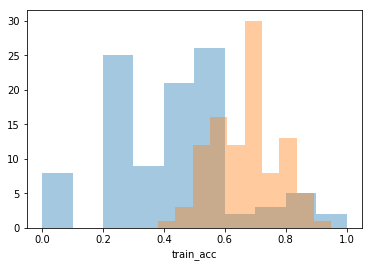

In [190]:
print(summary['train_acc'].median())

a = summary[summary.train_acc == 1]
print(len(a))
print(a['test_acc'].mean())

b = summary[(summary.train_acc > 0.6) & (summary.train_acc < 1)]
print(len(b))
print(b['test_acc'].mean())

c = summary[(summary.train_acc <= 0.6)]
print(len(c))
print(c['test_acc'].mean())


sns.distplot(summary.test_acc,bins = 10,kde = False)
sns.distplot(summary.train_acc,bins = 10,kde = False)




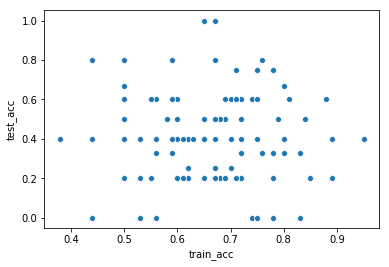

In [191]:
sns.scatterplot(summary.train_acc,summary.test_acc)

In [192]:
cat_predict_outcome = []
for i in summary['predict outcome']:
    cat_predict_outcome.extend(i)
cat_actual_outcome = []
for i in summary['actual outcome']:
    cat_actual_outcome.extend(i)
hi = list(zip(cat_predict_outcome, cat_actual_outcome))
date = df.index[-len(cat_predict_outcome):]

the_outcome = pd.DataFrame(hi , index = date, columns = ['predict_outcome','actual_outcome'])
the_outcome['compare'] = the_outcome.predict_outcome - the_outcome.actual_outcome
the_outcome['DoW'] = the_outcome.index.map(lambda x: x.weekday())


In [193]:
correct = the_outcome[the_outcome.compare == 0]
dead_wrong = the_outcome[abs(the_outcome.compare) == 2]

print (f'Acc: {len(correct)/ len(the_outcome)} _ {len(dead_wrong)/ len(the_outcome)}')

predict0 = the_outcome[the_outcome.predict_outcome == 0]
correct0 = predict0[the_outcome.actual_outcome == 0]
dead_wrong0 = predict0[the_outcome.actual_outcome == 2]
print (f'0_precision: {len(correct0)/len(predict0)}_{len(dead_wrong0)/len(predict0)}')
predict2 = the_outcome[the_outcome.predict_outcome == 2]
correct2 = predict2[the_outcome.actual_outcome == 2]
dead_wrong2 = predict2[the_outcome.actual_outcome == 0]
print (f'2_precision: {len(correct2)/len(predict2)}_{len(dead_wrong2)/len(predict2)}')

print(f'predict0: {len(predict0)/len(the_outcome)} _ predict2: {len(predict2)/len(the_outcome)}')
print(f'actual0: {len(the_outcome[the_outcome.actual_outcome == 0])/len(the_outcome)}_ actual2: {len(the_outcome[the_outcome.actual_outcome == 2])/len(the_outcome)}')

Acc: 0.4043956043956044 _ 0.3274725274725275
0_precision: 0.4066390041493776_0.34854771784232363
2_precision: 0.4393063583815029_0.37572254335260113
predict0: 0.5296703296703297 _ predict2: 0.3802197802197802
actual0: 0.4_ actual2: 0.378021978021978


In [197]:
print(f'according to DoW')
for i in range(5):
    i_days = the_outcome[the_outcome.DoW == i]
    correct = i_days[i_days.compare == 0]
    dead_wrong = i_days[abs(i_days.compare) == 2]
    print(f'{len(correct)/ len(i_days)} _ {len(dead_wrong)/ len(i_days)}')


according to DoW
0.38372093023255816 _ 0.3372093023255814
0.4943820224719101 _ 0.29213483146067415
0.40217391304347827 _ 0.31521739130434784
0.3763440860215054 _ 0.34408602150537637
0.3684210526315789 _ 0.3473684210526316


In [14]:
# 0.3880597014925373 _ 0.34328358208955223
# 0.5223880597014925 _ 0.2537313432835821
# 0.47761194029850745 _ 0.31343283582089554
# 0.43283582089552236 _ 0.31343283582089554
# 0.3880597014925373 _ 0.34328358208955223

### the following is backtesting the strategy

In [198]:
predict_array = []
for i in summary['predict outcome']:
    predict_array.extend(i)

date = df.index[-len(predict_array):]

strategy = pd.DataFrame(predict_array, columns = ['predict_outcome'], index = date)

strategy['DoW'] = strategy.index.map(lambda x: x.weekday())

strat_entry_price = []
strat_exit_price = []
for i in list(strategy.index):
    strat_entry_price.append(candles[(candles.date == i) & (candles.time == dt.time(9,45))].open.values[0])
    strat_exit_price.append(candles[(candles.date == i) & (candles.time == dt.time(16,25))].close.values[0])


strategy['entry_price'] = strat_entry_price
strategy['closing_price'] = strat_exit_price




In [199]:
from IPython.display import display, HTML

strategy['p_l'] = (strategy['closing_price'] - strategy['entry_price']) * -(strategy['predict_outcome'] - 1)
display(strategy)


print(f'p_l = {strategy.p_l.sum()}')
print('\n')
print(f'stats with 1')
print(f'PP: {len(strategy[strategy.p_l > 0])/len(strategy)}')
print(f'Avg: {strategy.p_l.mean()}')
print(f'SD: {strategy.p_l.std(ddof = 0)}')
print(f'SR: {strategy.p_l.mean()/strategy.p_l.std(ddof = 0)}')

strategy_wo1 = strategy[strategy.predict_outcome != 1]

print('\n')
print(f'stats without 1')
print(f'PP: {len(strategy_wo1[strategy_wo1.p_l > 0])/len(strategy_wo1)}')
print(f'Avg: {strategy_wo1.p_l.mean()}')
print(f'SD: {strategy_wo1.p_l.std(ddof = 0)}')
print(f'SR: {strategy_wo1.p_l.mean()/strategy_wo1.p_l.std(ddof = 0)}')


for i in range(5):
    hihi = strategy_wo1[strategy_wo1.DoW == i]
    print('\n')
    print(f'Only for day of week {i+1}: {len(hihi)}')
    print(f'PP: {len(hihi[hihi.p_l > 0])/len(hihi)}')
    print(f'Avg: {hihi.p_l.mean()}')
    print(f'SD: {hihi.p_l.std(ddof = 0)}')
    print(f'SR: {hihi.p_l.mean()/hihi.p_l.std(ddof = 0)}')


,predict_outcome,DoW,entry_price,closing_price,p_l
2016-11-28,0.0,0,22832.0,22800.0,-32.0
2016-11-29,0.0,1,22820.0,22804.0,-16.0
2016-11-30,0.0,2,22863.0,22822.0,-41.0
2016-12-01,0.0,3,22902.0,22894.0,-8.0
2016-12-02,0.0,4,22733.0,22575.0,-158.0
2016-12-05,0.0,0,22561.0,22580.0,19.0
2016-12-06,0.0,1,22725.0,22705.0,-20.0
2016-12-07,0.0,2,22799.0,22794.0,-5.0
2016-12-08,0.0,3,23031.0,22831.0,-200.0
2016-12-09,0.0,4,22790.0,22744.0,-46.0


p_l = 5764.0


stats with 1
PP: 0.48131868131868133
Avg: 12.668131868131868
SD: 183.059606505293
SR: 0.0692022238546961


stats without 1
PP: 0.5289855072463768
Avg: 13.922705314009661
SD: 191.86468363788023
SR: 0.07256523217314431


Only for day of week 1: 82
PP: 0.5487804878048781
Avg: 28.23170731707317
SD: 170.52124528107055
SR: 0.16556123121514146


Only for day of week 2: 82
PP: 0.5121951219512195
Avg: 17.536585365853657
SD: 215.83723514756474
SR: 0.08124911975389303


Only for day of week 3: 83
PP: 0.6024096385542169
Avg: 25.867469879518072
SD: 225.94613768454275
SR: 0.11448511642908998


Only for day of week 4: 83
PP: 0.4578313253012048
Avg: 4.036144578313253
SD: 182.15705164679682
SR: 0.022157498388474972


Only for day of week 5: 84
PP: 0.5238095238095238
Avg: -5.607142857142857
SD: 153.32148125962735
SR: -0.036571149789819644
